In [1]:
!pip install torch_geometric

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool

In [3]:
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=NormalizeFeatures())
data = dataset[0]

In [4]:
def visualize_graph(data):
    plt.figure(figsize=(8, 8))
    G = to_networkx(data, to_undirected=True)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
    plt.title("Graph Visualization (Chemical Compound)")
    plt.show()

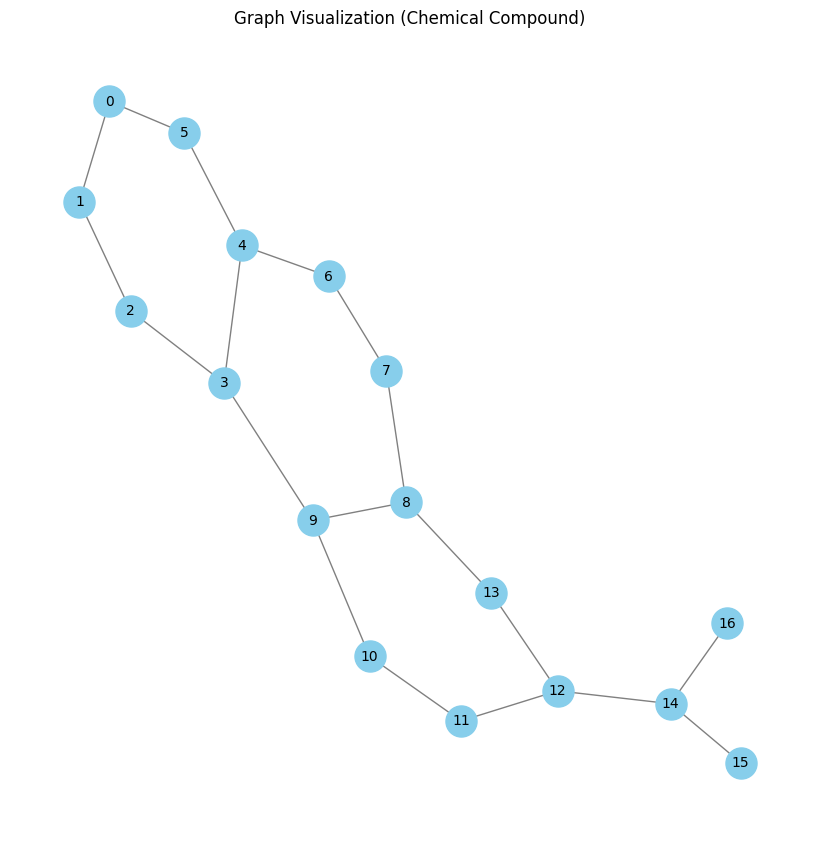

In [5]:
visualize_graph(data)

In [6]:
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')


print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Edge indices: {data.edge_index}')
print(f'Node features: {data.x}')
print(f'Graph label: {data.y}')

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Edge indices: tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])
Node features: tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
    

In [7]:
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GraphSAGEModel, self).__init__()

        self.sage1 = SAGEConv(num_node_features, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)
        self.sage3 = SAGEConv(hidden_channels, hidden_channels)

        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.sage1(x, edge_index)
        x = torch.relu(x)
        x = self.sage2(x, edge_index)
        x = torch.relu(x)
        x = self.sage3(x, edge_index)
        x = torch.relu(x)

        x = global_mean_pool(x, batch)

        x = self.fc(x)

        return torch.log_softmax(x, dim=1)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
dataset = dataset.shuffle()
train_dataset = dataset[:150]
test_dataset = dataset[150:]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
model = GraphSAGEModel(dataset.num_node_features, hidden_channels=64, num_classes=dataset.num_classes).to(device)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [12]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

In [13]:
epochs = 100
for epoch in range(epochs):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch 0, Loss: 0.6758, Train Acc: 0.6533, Test Acc: 0.7105
Epoch 10, Loss: 0.6087, Train Acc: 0.6667, Test Acc: 0.7105
Epoch 20, Loss: 0.5344, Train Acc: 0.7400, Test Acc: 0.7632
Epoch 30, Loss: 0.5223, Train Acc: 0.7533, Test Acc: 0.7895
Epoch 40, Loss: 0.4911, Train Acc: 0.7467, Test Acc: 0.8421
Epoch 50, Loss: 0.5043, Train Acc: 0.7600, Test Acc: 0.8421
Epoch 60, Loss: 0.4978, Train Acc: 0.7600, Test Acc: 0.8421
Epoch 70, Loss: 0.5108, Train Acc: 0.7667, Test Acc: 0.8684
Epoch 80, Loss: 0.4942, Train Acc: 0.7600, Test Acc: 0.8421
Epoch 90, Loss: 0.4949, Train Acc: 0.7733, Test Acc: 0.8684


In [14]:
def visualize_graph_embeddings(model, loader):
    model.eval()

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            all_embeddings.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.hstack(all_labels)

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_labels, cmap='coolwarm', s=100)
    plt.colorbar(label="Graph Label")
    plt.title("t-SNE Visualization of Graph-Level Embeddings")
    plt.show()


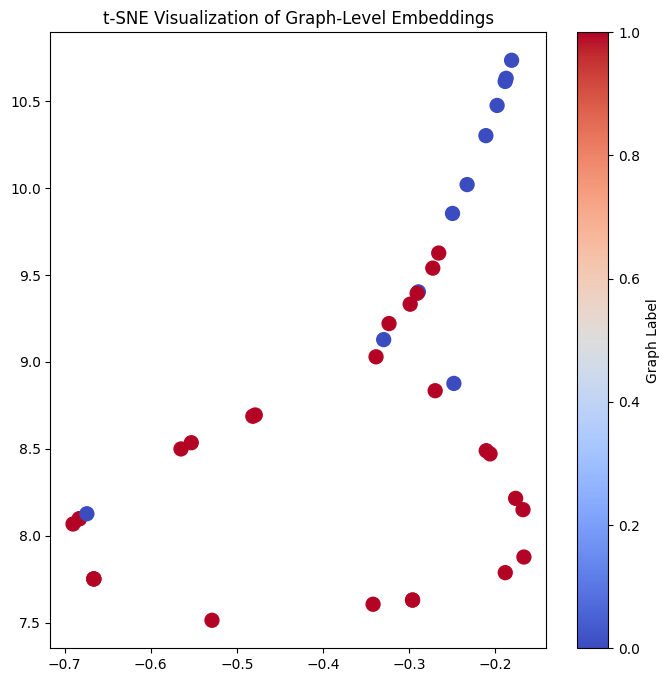

In [15]:
visualize_graph_embeddings(model, test_loader)

In [16]:
def plot_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1).cpu().numpy()
            all_preds.append(pred)
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.hstack(all_preds)
    all_labels = np.hstack(all_labels)

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Mutagenic', 'Mutagenic'],
                yticklabels=['Non-Mutagenic', 'Mutagenic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()


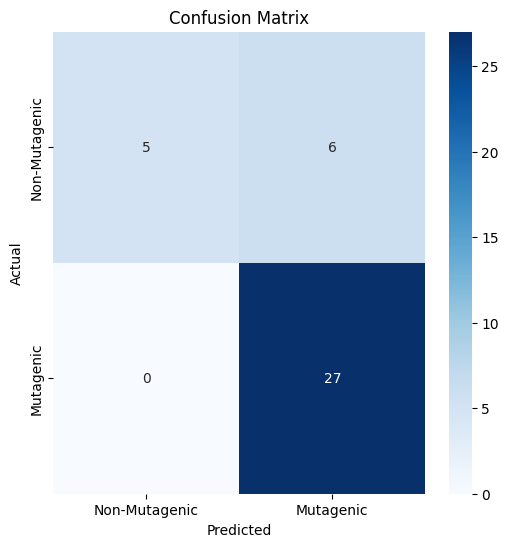

In [17]:
plot_confusion_matrix(model, test_loader)